In [4]:
from Tumor_Classifier_Utils import *

In [5]:
# loading in data
train, train_y, val, val_y, test, test_y, N, num_classes = load_data(64)


print(train.shape)
print(val.shape)
print(test.shape)
print(train_y.shape)
print(val_y.shape)
print(test_y.shape)

(2450, 64, 64, 1)
(350, 64, 64, 1)
(283, 64, 64, 1)
(2450, 1)
(350, 1)
(283, 1)


In [6]:
train_PCA = np.reshape(train[:,:,:,:], (2450, -1))
val_PCA = np.reshape(val[:,:,:,:], (350, -1))
test_PCA = np.reshape(test[:,:,:,:], (283, -1))

print(train_PCA.shape)
print(val_PCA.shape)
print(test_PCA.shape)

(2450, 4096)
(350, 4096)
(283, 4096)


In [7]:
pca = decomposition.PCA()
pca.fit(train_PCA)

PCA()

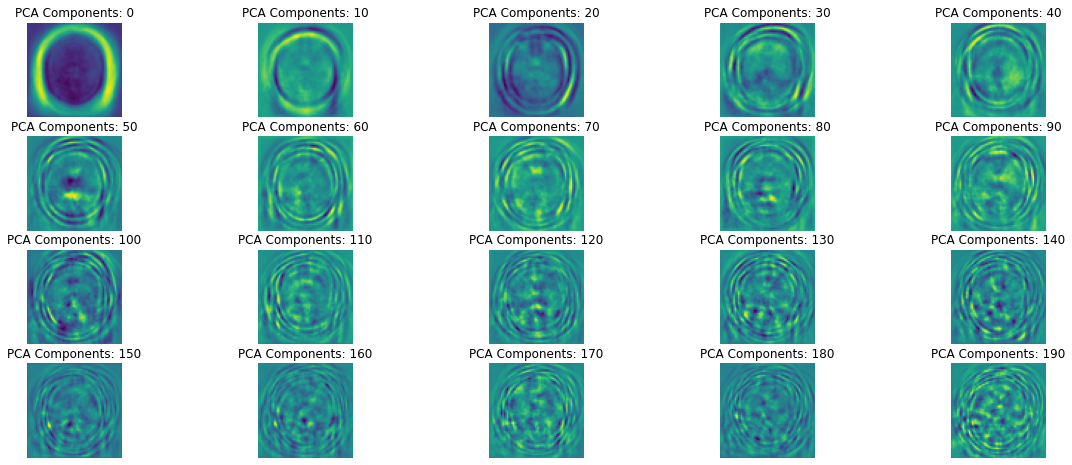

In [8]:
fig = plt.figure(figsize=[20, 8])
for i in range(20):
    ax = fig.add_subplot(4, 5, i + 1)
    pc = np.reshape(pca.components_[i*10,:], (N, N)) 
    ax.imshow(pc)
    ax.set_title("PCA Components: " + str(i*10))
    plt.axis('off')

In [9]:
transformed_train = pca.transform(train_PCA)
transformed_val = pca.transform(val_PCA)
transformed_test = pca.transform(test_PCA)

In [10]:
cumulative_sum = np.cumsum(pca.explained_variance_ratio_, axis=0)
top90 = np.where(cumulative_sum > 0.90)[0][0]
top95 = np.where(cumulative_sum > 0.95)[0][0]
top99 = np.where(cumulative_sum > 0.99)[0][0]

top90: 287, top95: 491, top99: 1051


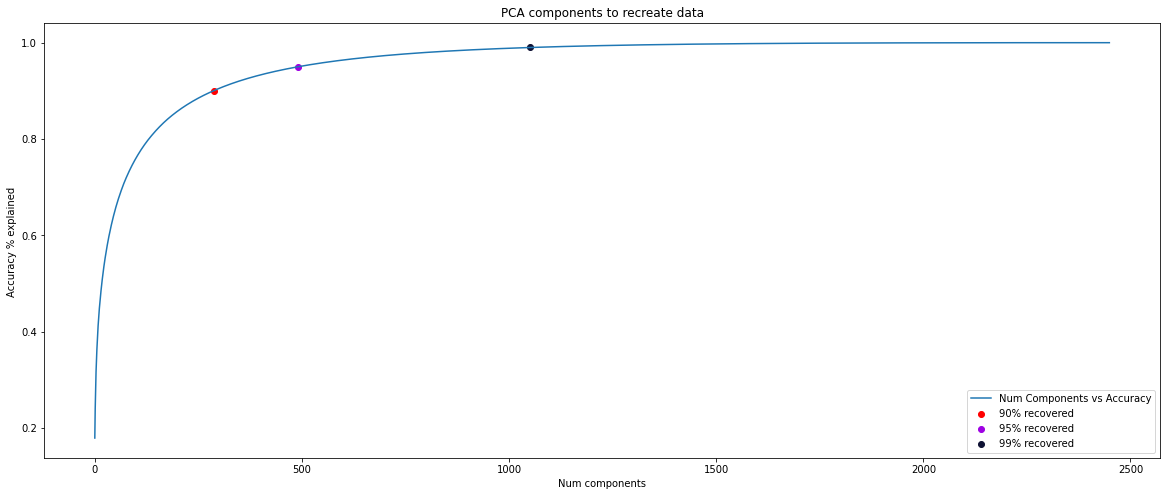

In [11]:
plot_cumulative_sum(cumulative_sum, top90, top95, top99)

(2450, 2450)
(2450, 4096)


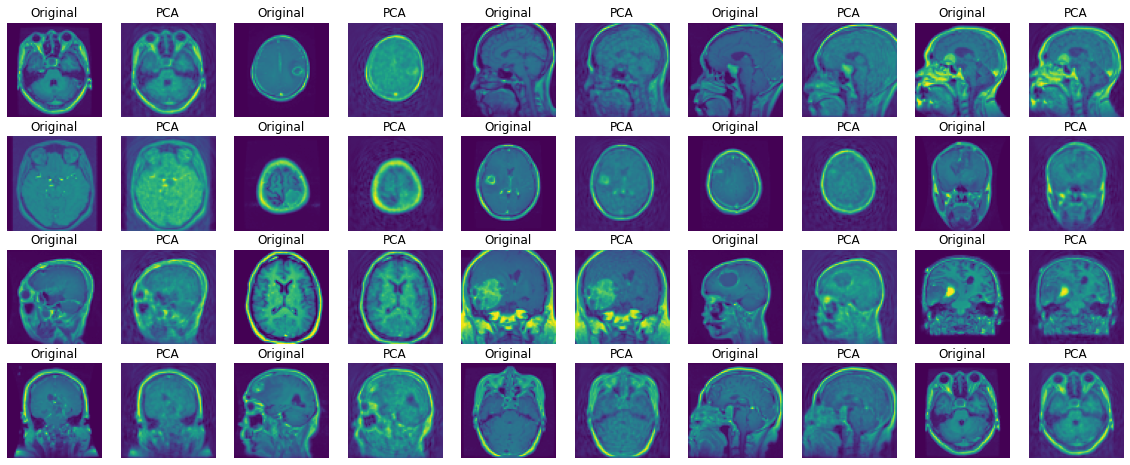

In [12]:
transformed_train_95 = transformed_train
transformed_train_95[:,top95+1:] = 0
print(transformed_train_95.shape)

transform_top95_generate = pca.inverse_transform(transformed_train_95)
print(transform_top95_generate.shape)

fig = plt.figure(figsize=[20, 8])
for i in range(20):
    ax = fig.add_subplot(4, 10, 2*i + 1)
    ax.imshow(np.reshape(train_PCA[i,:], (N,N)))
    ax.set_title('Original')
    ax.axis('off')
    ax = fig.add_subplot(4, 10, 2*i + 2)
    pc = np.reshape(transform_top95_generate[i,:], (N, N)) 
    ax.imshow(pc)
    ax.set_title('PCA')
    ax.axis('off')

In [13]:
# choose to use 95% recreation
transformed_train_95 = transformed_train[:, 0:top95]
transformed_val_95 = transformed_val[:, 0:top95]
transformed_test_95 = transformed_test[:, 0:top95]

print(transformed_train_95.shape)
print(train_y.shape)

(2450, 491)
(2450, 1)


In [14]:
lda = discriminant_analysis.LinearDiscriminantAnalysis()
lda.fit(np.array(transformed_train_95), np.array(train_y))

transformed_train_LDA = lda.transform(transformed_train_95)
transformed_val_LDA = lda.transform(transformed_val_95)
transformed_test_LDA = lda.transform(transformed_test_95)

c:\Users\61424\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:1107: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [15]:
print(np.shape(transformed_train_LDA))

(2450, 3)


In [16]:
def search_hyperparams(model, params, X_train, Y_train, X_validate, Y_validate):
    # Create list of all possible combinations
    param_list = list(ParameterGrid(params))
    
    # Initialising 
    best_result = 0.00;
    best_params = param_list[0];
    worst_result = 1.00;
    worst_params = param_list[0];
    # looping through all parameters in parameter list
    for params in param_list:
        # creating model with set parameters
        model = model.set_params(**params)
        # training the model
        model.fit(X_train, Y_train)
        # retrieving model score
        result = model.score(X_validate, Y_validate)
        # checking if model score is better, then allocating best parameters
        if result > best_result:
            best_result = result
            best_params = params
        if result < worst_result:
            worst_result = result
            worst_params = params
    
    # Return the best
    print(best_params)
    print("Validation Accuracy " + str(best_result))
    print(worst_params)
    print("Validation Accuracy " + str(worst_result))
    return best_params

In [17]:
param_grid = {'class_weight': ['balanced'], 'decision_function_shape': ['ovo', 'ovr'], 'C': list(range(1, 30)), 'gamma': [0.00005, 0.0001, 0.0003, 0.0005], 'kernel' : ['rbf', 'sigmoid']}

# Find Optimal Hyperparameters and then create model
model = SVC()
best_params2 = search_hyperparams(model, param_grid, transformed_train_LDA, train_y, transformed_val_LDA, val_y)

svm = model.set_params(**best_params2)
svm.fit(transformed_train_LDA, train_y)

c:\Users\61424\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:1107: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\61424\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:1107: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\61424\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:1107: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\61424\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:1107: DataConve

{'C': 1, 'class_weight': 'balanced', 'decision_function_shape': 'ovo', 'gamma': 0.0001, 'kernel': 'rbf'}
Validation Accuracy 0.7257142857142858
{'C': 11, 'class_weight': 'balanced', 'decision_function_shape': 'ovo', 'gamma': 0.0005, 'kernel': 'rbf'}
Validation Accuracy 0.7057142857142857


SVC(C=1, class_weight='balanced', decision_function_shape='ovo', gamma=0.0001)

In [18]:
def eval_model(model, X_train, Y_train, X_test, Y_test):
    labels = ['No Tumour', 'Glioma', 'Meningioma', 'Pituitary']
    fig = plt.figure(figsize=[25, 8])
    ax = fig.add_subplot(1, 2, 1)
    conf = ConfusionMatrixDisplay.from_estimator(model, X_train, Y_train, normalize='true', ax=ax, display_labels=labels)
    #conf.ax_.set_title('Training Set Performance: %1.3f' % (sum(model.predict(X_train) == Y_train)/len(Y_train)));
    ax = fig.add_subplot(1, 2, 2)
    conf = ConfusionMatrixDisplay.from_estimator(model, X_test, Y_test, normalize='true', ax=ax, display_labels=labels)
    #conf.ax_.set_title('Testing Set Performance: %1.3f' % (sum(model.predict(X_test) == Y_test)/len(Y_test)));
    print(classification_report(Y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.17      0.62      0.26         8
           1       0.57      0.62      0.59       102
           2       0.71      0.55      0.62       127
           3       0.82      0.80      0.81        46

    accuracy                           0.62       283
   macro avg       0.57      0.65      0.57       283
weighted avg       0.67      0.62      0.63       283



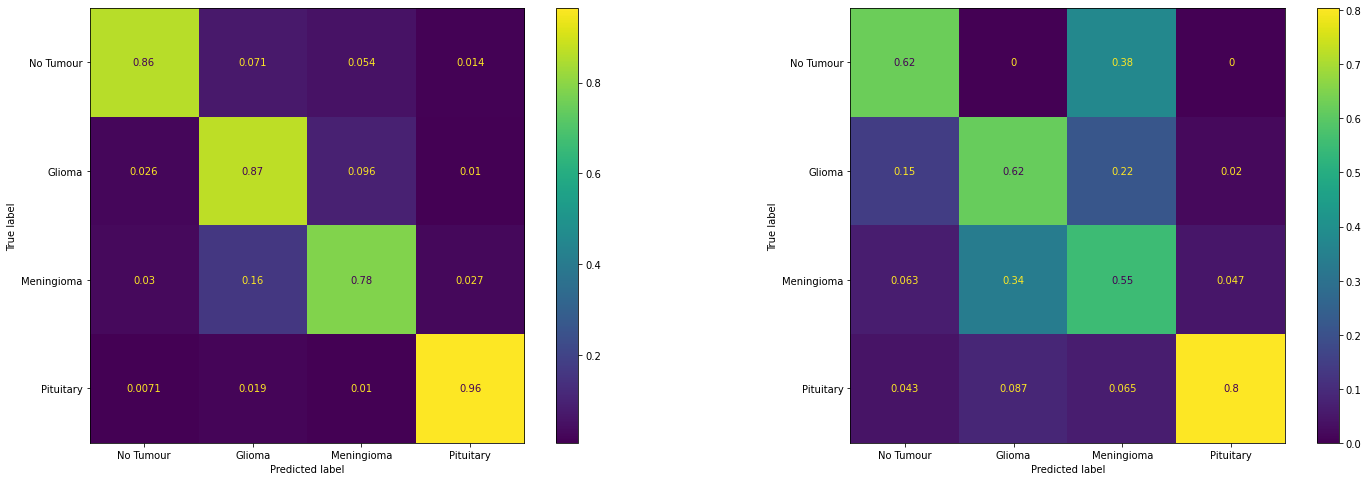

In [19]:
eval_model(svm, transformed_train_LDA, train_y, transformed_test_LDA, test_y)

(283, 3)


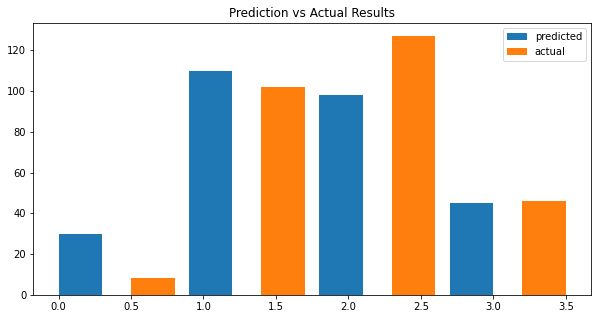

In [20]:
print(transformed_test_LDA.shape)
pred = svm.predict(transformed_test_LDA);

fig = plt.figure(figsize=[10, 5])
ax = fig.subplots()
ax.hist(pred)
test_thing = test_y[:] + 0.5
ax.hist(test_thing)
ax.set_title('Prediction vs Actual Results')
ax.legend(['predicted', 'actual'])